In [2]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from imblearn.over_sampling import SMOTE

import shap
import joblib

## Load the cleaned dataset

In [3]:
# Reading the Data
df = pd.read_csv('../data/ecommerce_churn_data_cleaned.csv')
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,9.0,Mobile Phone,1,8.0,UPI,Male,3.0,4,Mobile Phone,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,9.0,Mobile Phone,1,30.0,Debit Card,Male,2.0,4,Mobile Phone,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Mobile Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Mobile Phone,1,12.0,Credit Card,Male,3.0,3,Mobile Phone,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [3]:
df.info()
df['Churn'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5630 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5630 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5630 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

Churn
0    4682
1     948
Name: count, dtype: int64

In [4]:
# Seperate the features and target
X = df.drop(columns=['Churn', 'CustomerID'])
y = df['Churn']                                

In [5]:
# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:
    
    # Print the column name and the unique values
    print(f"{col}: {df[col].unique()}")

PreferredLoginDevice: ['Mobile Phone' 'Computer']
PreferredPaymentMode: ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
Gender: ['Female' 'Male']
PreferedOrderCat: ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
MaritalStatus: ['Single' 'Divorced' 'Married']


## One Hot Encoding for object datatype

In [7]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [8]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')  # drop_first avoids dummy variable trap
X_ohe_array = ohe.fit_transform(X[categorical_cols])

# Convert back to DataFrame with proper column names
X_ohe_cat = pd.DataFrame(X_ohe_array, columns=ohe.get_feature_names_out(categorical_cols))
X_ohe = pd.concat([X.drop(columns=categorical_cols).reset_index(drop=True), X_ohe_cat], axis=1)

In [9]:
print(X_ohe.shape)

(5630, 25)


## Linear Algorithms (Logistic Regression, SVM, etc.)

### Handling outliers

In [10]:
# Select numerical columns in X_ohe
num_cols = X_ohe.select_dtypes(include=['float64', 'int64']).columns

# Cap each numerical column at 1st and 99th percentile
X_ohe_capped = X_ohe.copy()

for col in num_cols:
    lower = X_ohe_capped[col].quantile(0.01)
    upper = X_ohe_capped[col].quantile(0.99)
    X_ohe_capped[col] = X_ohe_capped[col].clip(lower, upper)

# Check
X_ohe_capped.describe()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
count,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,...,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000
mean,10.107282,1.654707,15.526643,2.941385,3.688988,3.066785,4.207282,0.284902,15.668739,1.691652,...,0.411012,0.109059,0.073535,0.601066,0.072824,0.364121,0.369449,0.046892,0.530373,0.319005
std,8.264387,0.915389,8.063828,0.688543,1.023999,1.380194,2.553082,0.451408,3.574977,1.728751,...,0.492061,0.311740,0.261035,0.489723,0.259871,0.481225,0.482699,0.211426,0.499121,0.466133
min,0.000000,1.000000,6.000000,2.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,15.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,30.000000,3.000000,35.000000,4.000000,6.000000,5.000000,11.000000,1.000000,25.000000,9.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Standard Scalar

In [12]:
scaler = StandardScaler()
X_ohe_capped[num_cols] = scaler.fit_transform(X_ohe_capped[num_cols])

In [13]:
X_ohe_capped.describe()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
count,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,...,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03,5.630000e+03
mean,9.086870e-17,7.256875e-18,-5.048261e-18,2.827026e-16,-4.038609e-17,-1.135859e-16,-2.019304e-17,-4.259470e-17,-1.817374e-16,2.019304e-17,...,-5.915931e-17,-2.839647e-18,-4.953606e-17,-8.045666e-17,7.414633e-17,-3.218266e-17,4.101712e-17,-1.656461e-17,1.009652e-17,-6.468084e-18
std,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,...,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00
min,-1.223101e+00,-7.152859e-01,-1.181510e+00,-1.367336e+00,-2.626201e+00,-1.497592e+00,-1.256351e+00,-6.311975e-01,-1.306065e+00,-9.786271e-01,...,-8.353614e-01,-3.498690e-01,-2.817289e-01,-1.227468e+00,-2.802571e-01,-7.567204e-01,-7.654512e-01,-2.218077e-01,-1.062709e+00,-6.844270e-01
25%,-8.600655e-01,-7.152859e-01,-8.094447e-01,-1.367336e+00,-6.729002e-01,-7.729924e-01,-8.646328e-01,-6.311975e-01,-7.465716e-01,-4.001233e-01,...,-8.353614e-01,-3.498690e-01,-2.817289e-01,-1.227468e+00,-2.802571e-01,-7.567204e-01,-7.654512e-01,-2.218077e-01,-1.062709e+00,-6.844270e-01
50%,-1.339943e-01,-7.152859e-01,-1.893367e-01,8.513602e-02,3.037505e-01,-4.839247e-02,-4.729146e-01,-6.311975e-01,-1.870777e-01,-4.001233e-01,...,-8.353614e-01,-3.498690e-01,-2.817289e-01,8.146850e-01,-2.802571e-01,-7.567204e-01,-7.654512e-01,-2.218077e-01,9.409918e-01,-6.844270e-01
75%,5.920769e-01,1.469771e+00,5.547929e-01,8.513602e-02,3.037505e-01,6.762075e-01,7.022402e-01,1.584290e+00,6.521632e-01,1.783806e-01,...,1.197087e+00,-3.498690e-01,-2.817289e-01,8.146850e-01,-2.802571e-01,1.321492e+00,1.306419e+00,-2.218077e-01,9.409918e-01,1.461076e+00
max,2.407255e+00,1.469771e+00,2.415117e+00,1.537608e+00,2.257052e+00,1.400807e+00,2.660832e+00,1.584290e+00,2.610392e+00,4.227907e+00,...,1.197087e+00,2.858213e+00,3.549512e+00,8.146850e-01,3.568152e+00,1.321492e+00,1.306419e+00,4.508410e+00,9.409918e-01,1.461076e+00


In [14]:
# Check if everything is 0 or not
X_ohe_capped.isnull().sum()

Tenure                                 0
CityTier                               0
WarehouseToHome                        0
HourSpendOnApp                         0
NumberOfDeviceRegistered               0
SatisfactionScore                      0
NumberOfAddress                        0
Complain                               0
OrderAmountHikeFromlastYear            0
CouponUsed                             0
OrderCount                             0
DaySinceLastOrder                      0
CashbackAmount                         0
PreferredLoginDevice_Mobile Phone      0
PreferredPaymentMode_Credit Card       0
PreferredPaymentMode_Debit Card        0
PreferredPaymentMode_E wallet          0
PreferredPaymentMode_UPI               0
Gender_Male                            0
PreferedOrderCat_Grocery               0
PreferedOrderCat_Laptop & Accessory    0
PreferedOrderCat_Mobile Phone          0
PreferedOrderCat_Others                0
MaritalStatus_Married                  0
MaritalStatus_Si

In [15]:
X_ohe_capped.head()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,-0.739054,1.469771,-1.181510,0.085136,-0.67290,-0.772992,1.877395,1.584290,-1.306065,-0.400123,...,1.197087,-0.349869,-0.281729,-1.227468,-0.280257,1.321492,-0.765451,-0.221808,-1.062709,1.461076
1,-0.133994,-0.715286,-0.933466,0.085136,0.30375,-0.048392,1.093958,1.584290,-0.187078,-0.978627,...,-0.835361,-0.349869,3.549512,0.814685,-0.280257,-0.756720,1.306419,-0.221808,-1.062709,1.461076
2,-0.133994,-0.715286,1.795009,-1.367336,0.30375,-0.048392,0.702240,1.584290,-0.466825,-0.978627,...,1.197087,-0.349869,-0.281729,0.814685,-0.280257,-0.756720,1.306419,-0.221808,-1.062709,1.461076
3,-1.223101,1.469771,-0.065315,-1.367336,0.30375,1.400807,1.485677,-0.631198,2.050898,-0.978627,...,1.197087,-0.349869,-0.281729,0.814685,-0.280257,1.321492,-0.765451,-0.221808,-1.062709,1.461076
4,-1.223101,-0.715286,-0.437380,0.085136,-0.67290,1.400807,-0.472915,-0.631198,-1.306065,-0.400123,...,-0.835361,-0.349869,-0.281729,0.814685,-0.280257,-0.756720,1.306419,-0.221808,-1.062709,1.461076


### Logistic Regression

In [17]:
# Train test split

# Split X_ohe_capped
X_train, X_test, y_train, y_test = train_test_split(
    X_ohe_capped, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
# Initialize Logistic Regression

logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

In [19]:
# Train the model
logreg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [20]:
# # Predict classes
y_pred = logreg.predict(X_test)

# Predict probabilities for ROC-AUC
y_prob = logreg.predict_proba(X_test)[:,1]

In [21]:
# Basic metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7930728241563055
Precision: 0.4410958904109589
Recall: 0.8473684210526315
F1 Score: 0.5801801801801801
ROC-AUC: 0.886274179037337

Confusion Matrix:
 [[732 204]
 [ 29 161]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.78      0.86       936
           1       0.44      0.85      0.58       190

    accuracy                           0.79      1126
   macro avg       0.70      0.81      0.72      1126
weighted avg       0.87      0.79      0.82      1126



### Using SMOTE

In [23]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train.copy(), y_train.copy())

logreg.fit(X_res, y_res)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]

print("LogReg With SMOTE:", accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_prob))

LogReg With SMOTE: 0.7948490230905861 0.8852732793522267


Handled class imbalance using balanced class weights. Tested SMOTE oversampling, but it showed minimal improvement, so final model uses class weights. Achieved Accuracy: 0.793, ROC-AUC: 0.886.

In [25]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

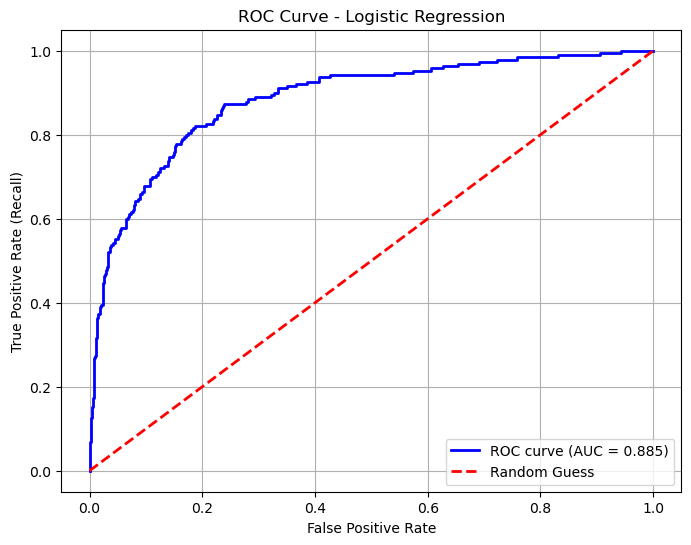

In [26]:
# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### SVM

In [28]:
linear_svm = SVC(
    kernel='linear',        # Linear kernel
    class_weight='balanced', # handle class imbalance
    probability=True,       # needed for ROC-AUC
    random_state=42
)

In [29]:
linear_svm.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [30]:
y_pred_svm = linear_svm.predict(X_test)
y_prob_svm = linear_svm.predict_proba(X_test)[:, 1]

In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_svm))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Accuracy: 0.8028419182948491
Precision: 0.45454545454545453
Recall: 0.8421052631578947
F1 Score: 0.5904059040590406
ROC-AUC: 0.8835863697705802

Confusion Matrix:
 [[744 192]
 [ 30 160]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.87       936
           1       0.45      0.84      0.59       190

    accuracy                           0.80      1126
   macro avg       0.71      0.82      0.73      1126
weighted avg       0.88      0.80      0.82      1126



### Using SMOTE

In [32]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train.copy(), y_train.copy())

linear_svm.fit(X_res, y_res)
y_pred = linear_svm.predict(X_test)
y_prob = linear_svm.predict_proba(X_test)[:,1]

print("Linear SVM With SMOTE:", accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_prob))

Linear SVM With SMOTE: 0.80550621669627 0.8844073324336483


Used balanced class weights to address imbalance. SMOTE was tested but did not significantly improve metrics. Final linear SVM achieves Accuracy: 0.802, ROC-AUC: 0.883.

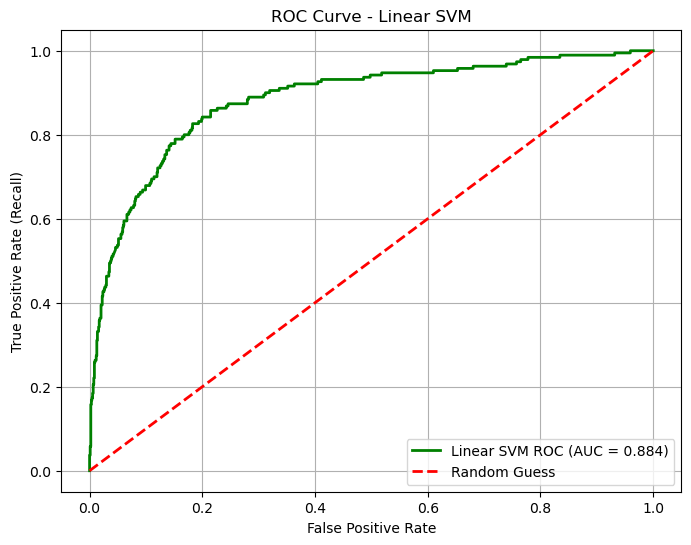

In [33]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8,6))
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'Linear SVM ROC (AUC = {roc_auc_svm:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Linear SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Label Encoding for Object datatype

In [35]:
X_le = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_le[col] = le.fit_transform(X_le[col])
    label_encoders[col] = le 
    print(f"{col} unique values after Label Encoding: {list(X_le[col].unique())}")

PreferredLoginDevice unique values after Label Encoding: [1, 0]
PreferredPaymentMode unique values after Label Encoding: [2, 4, 1, 0, 3]
Gender unique values after Label Encoding: [0, 1]
PreferedOrderCat unique values after Label Encoding: [2, 3, 4, 0, 1]
MaritalStatus unique values after Label Encoding: [2, 0, 1]


In [36]:
print("Label Encoded shape:", X_le.shape)

Label Encoded shape: (5630, 18)


In [37]:
from sklearn.model_selection import train_test_split

# Split label-encoded dataset
X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(
    X_le, y, test_size=0.2, random_state=42, stratify=y
)

## Decision Tree

In [39]:
# Initialise the Decision Tree
dt = DecisionTreeClassifier(random_state=42, 
                            class_weight='balanced')

In [40]:
# Fit
dt.fit(X_train_le, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [41]:
# Predict
y_pred_dt = dt.predict(X_test_le)
y_prob_dt = dt.predict_proba(X_test_le)[:,1]

In [42]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Accuracy: 0.9600355239786856
Precision: 0.8961748633879781
Recall: 0.8631578947368421
F1 Score: 0.8793565683646113
ROC-AUC: 0.9214293747188483

Confusion Matrix:
 [[917  19]
 [ 26 164]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       936
           1       0.90      0.86      0.88       190

    accuracy                           0.96      1126
   macro avg       0.93      0.92      0.93      1126
weighted avg       0.96      0.96      0.96      1126



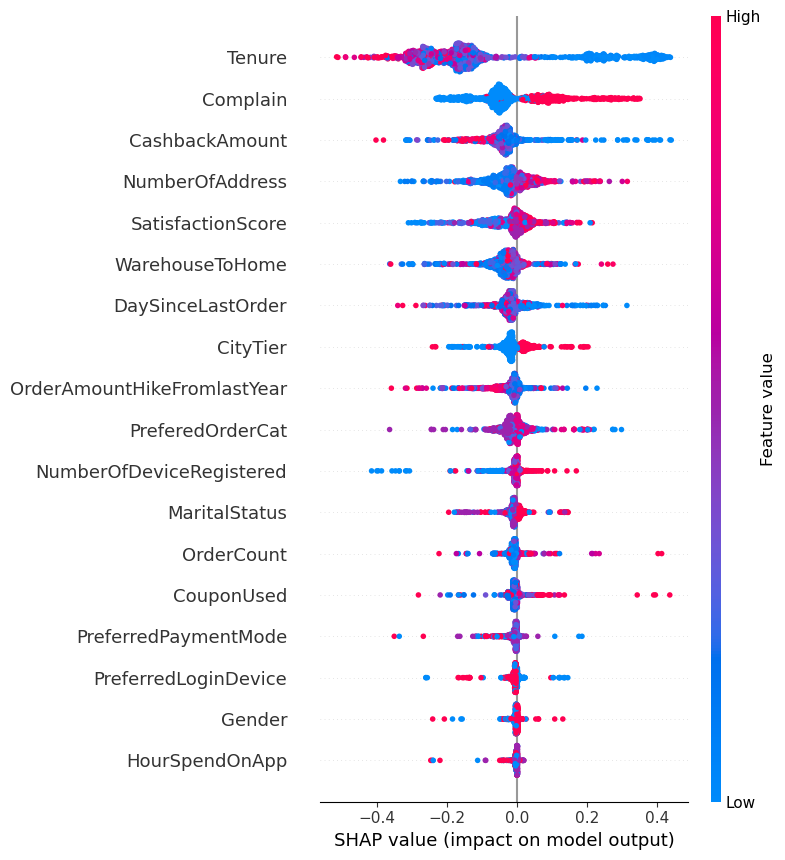

In [44]:
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_test_le)
shap.summary_plot(shap_values[:,:,1], X_test_le)

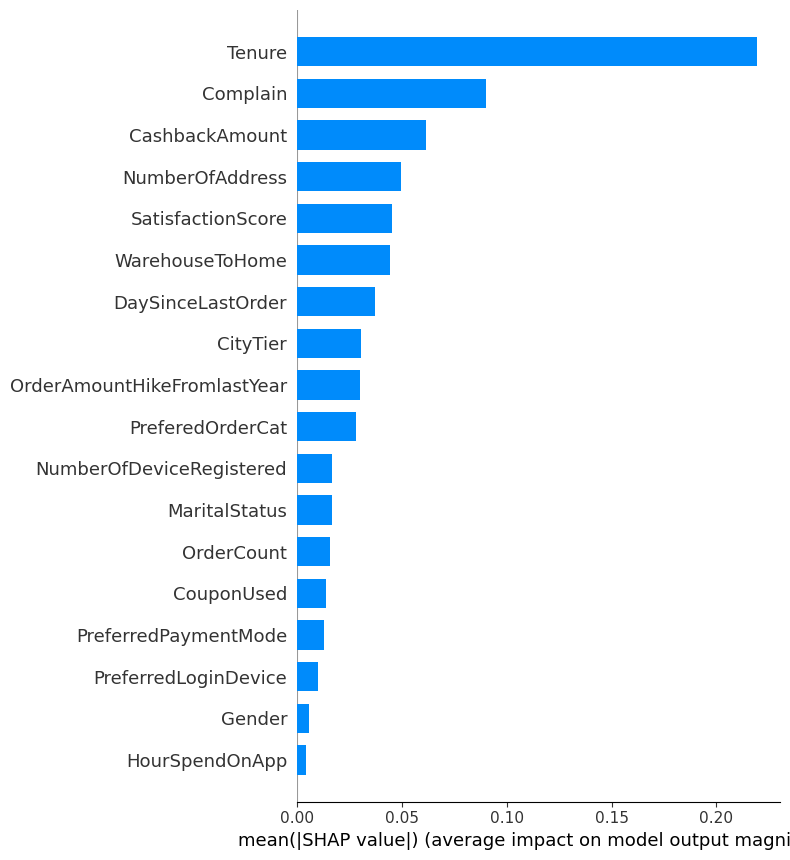

In [45]:
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_test_le)
shap.summary_plot(shap_values[:,:,1], X_test_le, plot_type= 'bar')

## Random Forest

In [47]:
# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=200,          # number of trees
    max_depth=None,             # let trees grow fully
    class_weight='balanced',    # handle imbalance
    random_state=42
)

In [48]:
# Train the model
rf.fit(X_train_le, y_train_le)   # use label-encoded X for trees

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [49]:
# Predict
y_pred_rf = rf.predict(X_test_le)
y_prob_rf = rf.predict_proba(X_test_le)[:, 1]

In [50]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.9831261101243339
Precision: 0.9776536312849162
Recall: 0.9210526315789473
F1 Score: 0.948509485094851
ROC-AUC: 0.999007534862798

Confusion Matrix:
 [[932   4]
 [ 15 175]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       936
           1       0.98      0.92      0.95       190

    accuracy                           0.98      1126
   macro avg       0.98      0.96      0.97      1126
weighted avg       0.98      0.98      0.98      1126



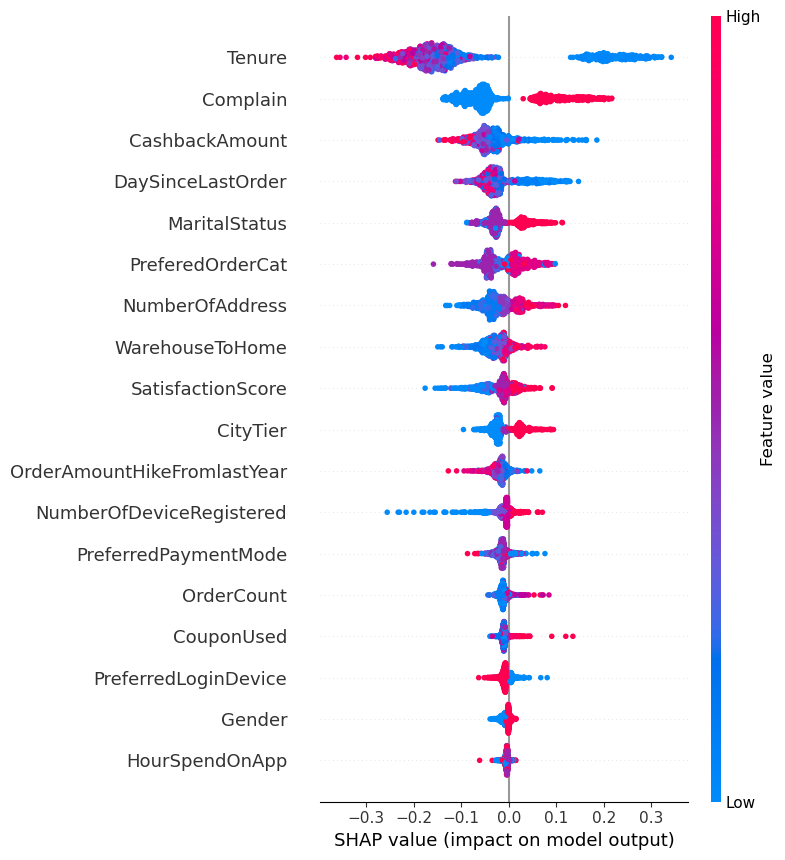

In [60]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_le)
shap.summary_plot(shap_values[:,:,1], X_test_le)

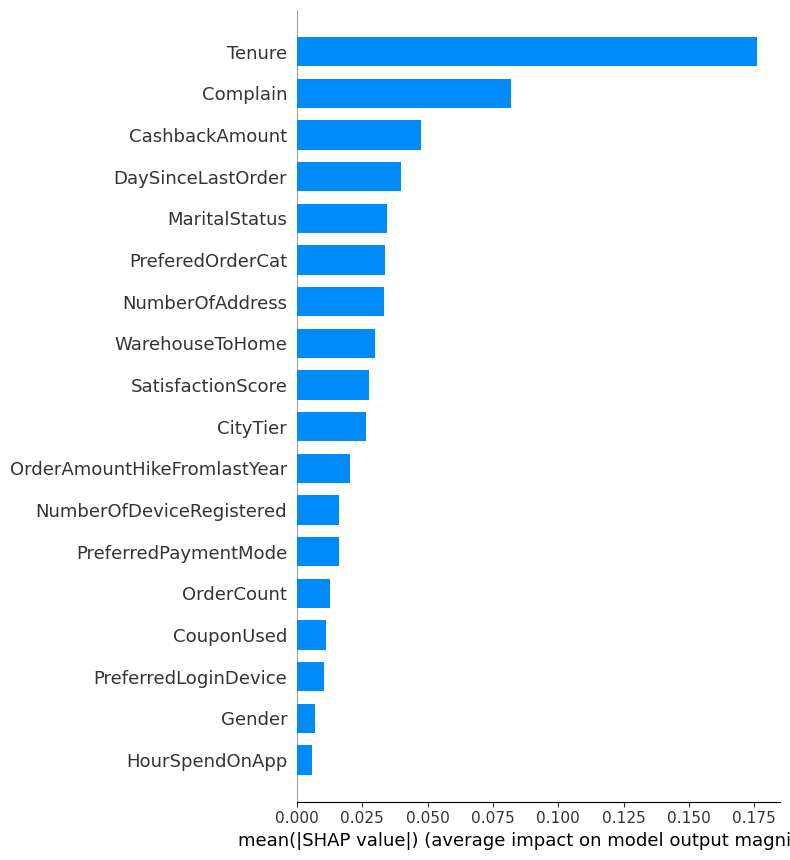

In [61]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_le)
shap.summary_plot(shap_values[:,:,1], X_test_le, plot_type= 'bar')

## XGBoost

In [55]:
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',  # avoids warning
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # handles imbalance
)

In [56]:
xgb.fit(X_train_le, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [57]:
y_pred_xgb = xgb.predict(X_test_le)
y_prob_xgb = xgb.predict_proba(X_test_le)[:, 1]

In [58]:
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

Accuracy: 0.9937833037300178
Precision: 0.9692307692307692
Recall: 0.9947368421052631
F1 Score: 0.9818181818181818
ROC-AUC: 0.9995838956365272

Confusion Matrix:
 [[930   6]
 [  1 189]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       936
           1       0.97      0.99      0.98       190

    accuracy                           0.99      1126
   macro avg       0.98      0.99      0.99      1126
weighted avg       0.99      0.99      0.99      1126



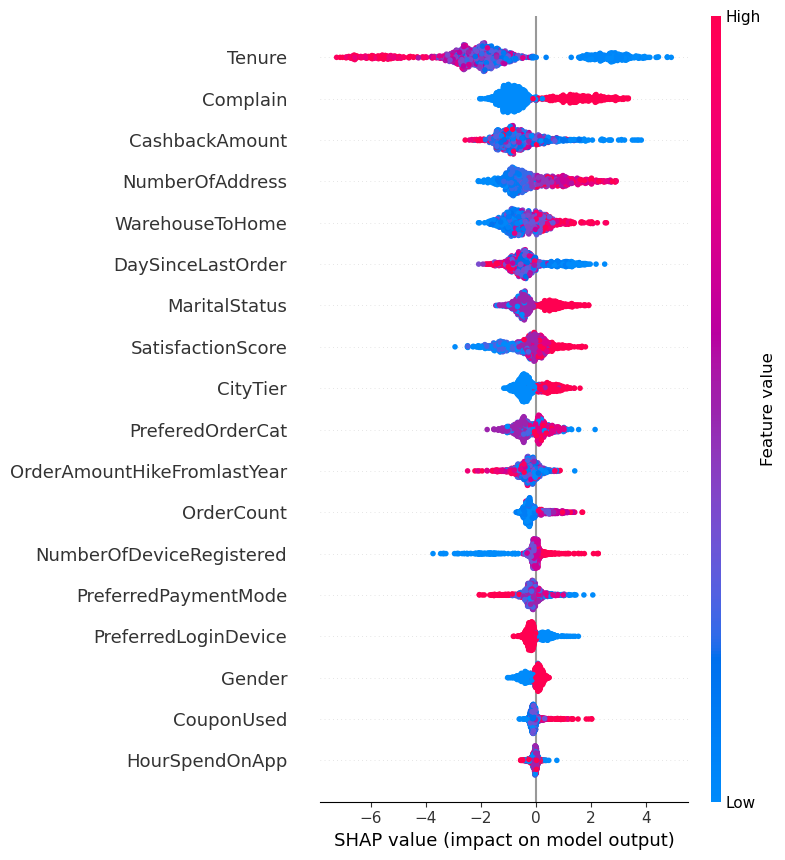

In [66]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_le)
shap.summary_plot(shap_values, X_test_le)

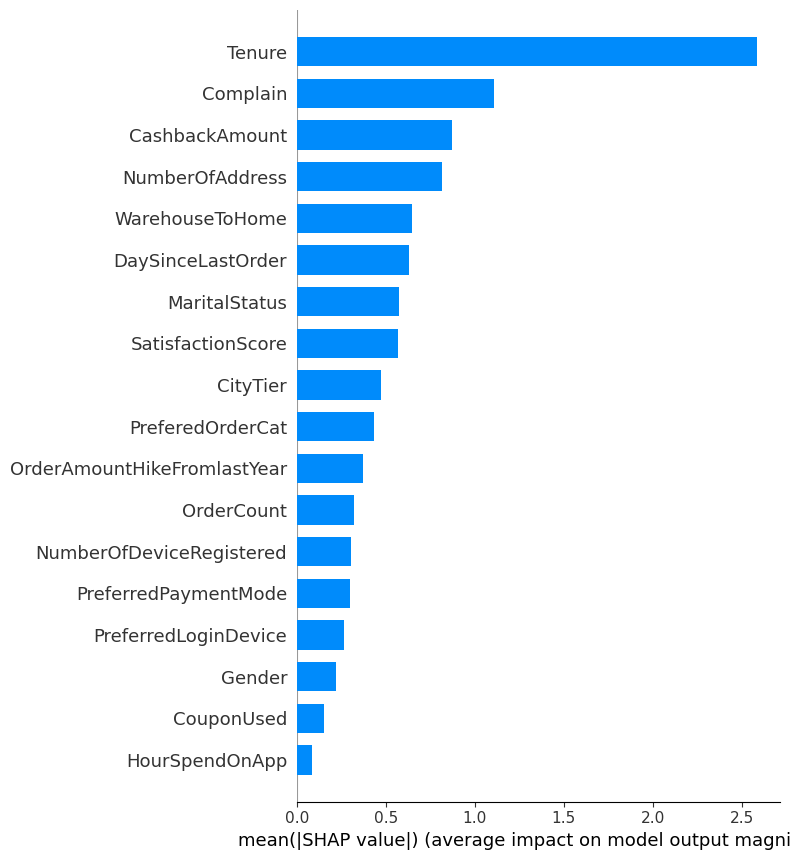

In [69]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_le)
shap.summary_plot(shap_values, X_test_le, plot_type= 'bar')

## Comparision

In [70]:
results = {
    'Model': ['Logistic Regression', 'SVM (Linear)', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.792, 0.802, 0.960, 0.983, 0.993],
    'Precision': [0.439, 0.454, 0.896, 0.977, 0.969],
    'Recall': [0.847, 0.842, 0.863, 0.921, 0.994],
    'F1 Score': [0.579, 0.590, 0.879, 0.948, 0.981],
    'ROC-AUC': [0.886, 0.883, 0.921, 0.999, 0.9995]
}

df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.792,0.439,0.847,0.579,0.8860
1,SVM (Linear),0.802,0.454,0.842,0.590,0.8830
2,Decision Tree,0.960,0.896,0.863,0.879,0.9210
3,Random Forest,0.983,0.977,0.921,0.948,0.9990
4,XGBoost,0.993,0.969,0.994,0.981,0.9995


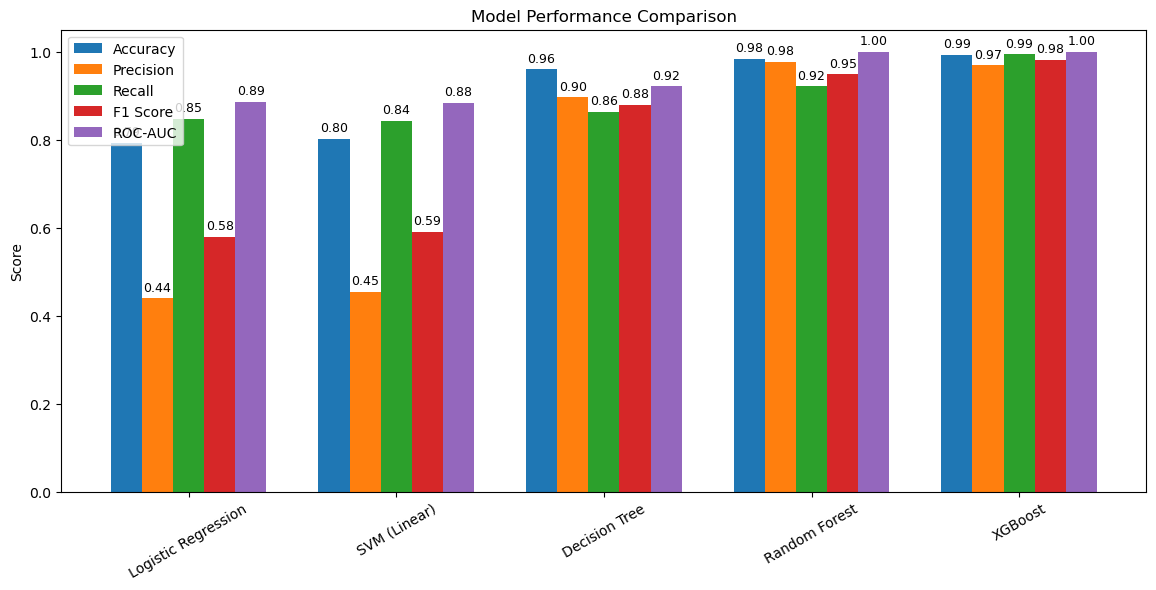

In [71]:
# Metrics and model names
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
models = df_results['Model']

# Set positions and width for bars
x = np.arange(len(models))
width = 0.15

plt.figure(figsize=(14,6))

# Plot each metric as a separate bar
for i, metric in enumerate(metrics):
    bars = plt.bar(x + i*width, df_results[metric], width, label=metric)
    
    # Label each bar with its value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)


# Labels & title
plt.xticks(x + width*2, models, rotation=30)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

## Cross Validation

In [72]:
# List of models and their corresponding X
models = ['Logistic Regression', 'SVM (Linear)', 'Decision Tree', 'Random Forest', 'XGBoost']
trained_models = [logreg, linear_svm, dt, rf, xgb]  # already trained
X_list = [X_ohe_capped, X_ohe_capped, X_le, X_le, X_le]  # match encoding for each
y_list = [y, y, y, y, y]  # same target

# Dictionary to store CV scores
cv_results = {}

for name, model, X_m, y_m in zip(models, trained_models, X_list, y_list):
    # 5-fold cross-validation for ROC-AUC
    scores = cross_val_score(model, X_m, y_m, cv=5, scoring='roc_auc')
    cv_results[name] = scores
    print(f"{name} ROC-AUC CV Scores: {scores}")
    print(f"Mean {name} ROC-AUC: {scores.mean()}\n")

Logistic Regression ROC-AUC CV Scores: [0.89373594 0.89476496 0.89107625 0.90315823 0.89480104]
Mean Logistic Regression ROC-AUC: 0.8955072824679071

SVM (Linear) ROC-AUC CV Scores: [0.89053081 0.89226833 0.89176226 0.90217005 0.89631437]
Mean SVM (Linear) ROC-AUC: 0.8946091631307607

Decision Tree ROC-AUC CV Scores: [0.97783963 0.9651372  0.97726608 0.96342882 0.974056  ]
Mean Decision Tree ROC-AUC: 0.971545547867516

Random Forest ROC-AUC CV Scores: [0.99999719 0.99972728 0.99978632 0.99973743 0.99987577]
Mean Random Forest ROC-AUC: 0.9998247987613544

XGBoost ROC-AUC CV Scores: [0.99999438 0.99907782 0.99986505 0.99902311 0.99990965]
Mean XGBoost ROC-AUC: 0.9995740022208878



## Save the models

In [74]:
# Save the models
joblib.dump(logreg, '../models/logistic_regression_model.pkl')
joblib.dump(linear_svm, '../models/svm_linear_model.pkl')
joblib.dump(dt, '../models/decision_tree_model.pkl')
joblib.dump(rf, '../models/random_forest_model.pkl')
joblib.dump(xgb, '../models/xgboost_model.pkl')

['xgboost_model.pkl']

In [75]:
joblib.dump(scaler, '../models/scaler.pkl')

['scaler.pkl']

In [76]:
joblib.dump(label_encoders, '../models/label_encoders.pkl')

['label_encoders.pkl']

In [77]:
joblib.dump(ohe, '../models/ohe.pkl')

['ohe.pkl']